# Using the 8 split datasets based on mass and jet number presence, we try ridge regression to predict outputs

## Dupplicate code from the dataset splitting

We have dupplicated it so as not to have git conflicts, but it should be the same with project1 - Alon.ipynb

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
# remove features with error values
y_jet = []
tx_jet = []
y_jet_nm = []
tx_jet_nm = []
# filtering according to undefinition due to jet number
idx_jet_undef = [np.array([0,1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                np.array([0,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]

# Extra filtering according to definition of mass
idx_jet_undef_nm = [np.array([1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                    np.array([1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]

for jet in range(4):
    idx_jet = (tX[:,22]==jet) & (tX[:,0] != -999)
    y_jet.append(y[idx_jet])
    tx_jet.append(tX[idx_jet][:,idx_jet_undef[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4): # NB : no mass also has dupplicates from data that has mass, to have more data available for training.
    idx_jet = tX[:,22]==jet
    y_jet_nm.append(y[idx_jet])
    tx_jet_nm.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4):
    print('Jet {:} shape is {:}'.format(jet,tx_jet[jet].shape))
    print('Jet no mass {:} shape is {:}'.format(jet,tx_jet_nm[jet].shape))

Jet 0 shape is (73790, 17)
Jet no mass 0 shape is (99913, 16)
Jet 1 shape is (69982, 22)
Jet no mass 1 shape is (77544, 21)
Jet 2 shape is (47427, 29)
Jet no mass 2 shape is (50379, 28)
Jet 3 shape is (20687, 29)
Jet no mass 3 shape is (22164, 28)


## Ridge regression implementation for this set

In [4]:
idx_col_select_split = []
y_split = []
tx_split = []

for jet in range(4):
    idx_jet = (tX[:,22]==jet) & (tX[:,0] != -999)
    y_split.append(y[idx_jet])
    tx_split.append(tX[idx_jet][:,idx_jet_undef[jet]])

for jet in range(4): # NB : no mass also has dupplicates from data that has mass, to have more data available for training.
    idx_jet = tX[:,22]==jet
    y_split.append(y[idx_jet])
    tx_split.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    
# print(y_split)
# print(tx_split[0][0])
for set_i in range(8):
    print(f'Set {set_i} shape is {tx_split[set_i].shape}')

Set 0 shape is (73790, 17)
Set 1 shape is (69982, 22)
Set 2 shape is (47427, 29)
Set 3 shape is (20687, 29)
Set 4 shape is (99913, 16)
Set 5 shape is (77544, 21)
Set 6 shape is (50379, 28)
Set 7 shape is (22164, 28)


For each of the datasets, we now have to train a model. We will use ridge regression, with different lambdas to find the best one. We use a high polynomial expansion because optimising for lambda should mean that any high degree will be compensated by the ridge regression when optimised. Therefore we use any high degree that guarantees our model is not limited by it's complexity.

In [5]:
from lab3_plots import plot_train_test
from th_helpers import build_poly, split_data, compute_rmse
from th_ridge_regression import ridge_regression

In [20]:
def ridge_regression_lambdas(x, y, degree, ratio, seed, lambdas):#=np.logspace(-5, 0, 15)):
    """Performs ridge regression with multiple lambdas."""
    # split the data, and return train and test data: TODO
    train_x, train_y, test_x, test_y = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function: TODO
    train_x_aug = build_poly(train_x, degree)
    test_x_aug = build_poly(test_x, degree)

    rmse_tr = []
    rmse_te = []
    
    min_w_te = []
    min_rmse_te = -1
    best_lambda = False
    best_correctness = -1
    
    for ind, lambda_ in enumerate(lambdas):

        # ridge regression with a given lambda        
        w = ridge_regression(train_y, train_x_aug, lambda_)
        
        rmse_tr.append(compute_rmse(train_y, train_x_aug, w))
        rmse_te.append(compute_rmse(test_y, test_x_aug, w))
        
        if rmse_te[ind] < min_rmse_te or min_rmse_te == -1:
            min_rmse_te = rmse_te[ind]
            min_w_te = w
            best_lambda = lambda_
            
        # ***************************************************
#         print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
#                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    
    # Compute correctness of best result 
    y_out_test = np.dot(test_x_aug, min_w_te)
    y_out_test[y_out_test>=0] = 1
    y_out_test[y_out_test<0] = -1
    best_correctness = 100*(y_out_test == test_y).tolist().count(True)/y_out_test.shape[0]
            
    # Plot the obtained results
    print(f"Degree={degree}, ratio={np.round(ratio, 3)}, seed={seed}, min test RMSE={np.round(min_rmse_te, 4)}, with correctness ={np.round(best_correctness, 2)}% ({len(y_out_test)} test points) and lambda={np.round(best_lambda, 7)}")
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    
    return min_rmse_te, min_w_te, best_lambda

# THEOTEST code
# ridge_regression_demo(x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).T, 
#                       y=np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]).T,
#                       degree = 3,
#                       ratio = 0.7,
#                       seed = 56)


Analysing set=0
Degree=8, ratio=0.9, seed=150, min test RMSE=0.739, with correctness =80.88% (7379 test points) and lambda=0.1829205


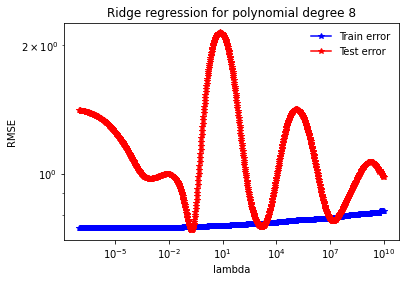


Analysing set=1
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7861, with correctness =79.28% (6998 test points) and lambda=1e-07


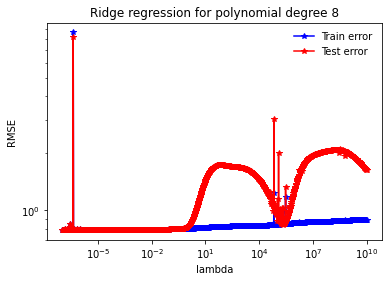


Analysing set=2
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7359, with correctness =82.84% (4743 test points) and lambda=1.57e-05


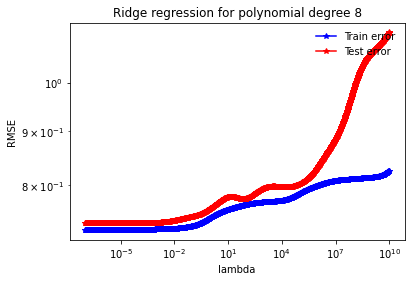


Analysing set=3
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7801, with correctness =81.34% (2069 test points) and lambda=0.6409244


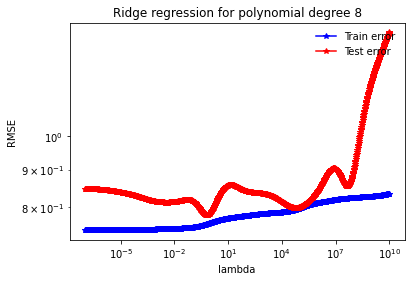


Analysing set=4
Degree=8, ratio=0.9, seed=150, min test RMSE=0.6881, with correctness =83.68% (9991 test points) and lambda=0.0903558


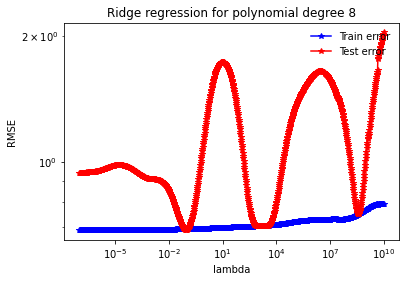


Analysing set=5
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7996, with correctness =77.79% (7754 test points) and lambda=1e-07


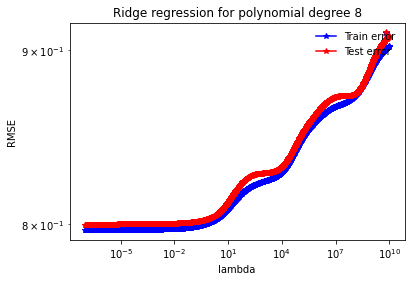


Analysing set=6
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7842, with correctness =79.44% (5038 test points) and lambda=8.13e-05


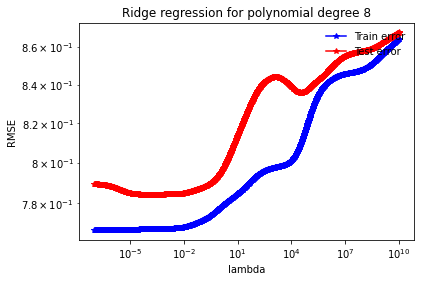


Analysing set=7
Degree=8, ratio=0.9, seed=150, min test RMSE=0.8071, with correctness =78.97% (2216 test points) and lambda=10.7654461


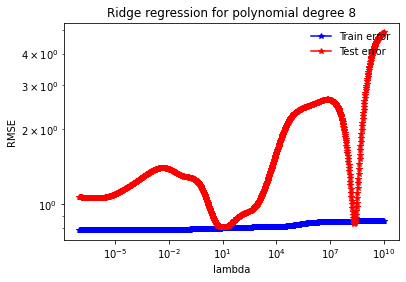

In [23]:
seed = 150
degree = 8
split_ratio = 0.9
lambdas = np.logspace(-7, 10, 1000)

for set_i in range(8):
    print(f"\nAnalysing set={set_i}")
    min_rmse_te, min_w_te, best_lambda = ridge_regression_lambdas(tx_split[set_i], y_split[set_i], degree, split_ratio, seed, lambdas)
    

## Now actual ridge regression with output file

We need to split the test data the same way, but keeping the ids in order to reconstruct it afterwards.

In [25]:
best_degrees = 8*[8]
best_lambdas = [0.1829205, 1e-07, 1.57e-05, 0.6409244, 0.0903558, 1e-07, 8.13e-05, 10.7654461]
print(best_degrees, best_lambdas)

[7, 7, 7, 7, 7, 7, 7, 7] [0.1829205, 1e-07, 1.57e-05, 0.6409244, 0.0903558, 1e-07, 8.13e-05, 10.7654461]
